![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# CNM of the flow past a circular cylinder

In this notebook, we create a reduced-order model (ROM) of the flow past a circular cylinder using on cluster-based network modeling (CNM). The input data are snapshots from a simulation of the flow past a 2D cylinder at a Reynolds number of 100. The flow is characterized by periodic vortex shedding behind the cylinder. We use only the quasi-steady data in this demonstration. For a detailed analysis of the data and more information about the setting, refer to the notebooks [SVD of the flow past a cylinder](svd_cylinder.ipynb) and [DMD of the flow past a circular cylinder](dmd_cylinder.ipynb).

In [1]:
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box
from flowtorch.rom import CNM, SVDEncoder

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Assembling the data matrix

The data matrix is assembled in the same way as in the notebooks linked above. We use all available snapshots in the quasi-steady (periodic) state and extract a region of interest around the cylinder. The individual snapshots form the column vectors of the data matrix.

In [2]:
path = DATASETS["of_cylinder2D_binary"]
loader = FOAMDataloader(path)
times = loader.write_times
window_times = [time for time in times if float(time) >= 4.0]

# load vertices, discard z-coordinate, and create a mask
vertices = loader.vertices[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

# assemble data matrix
data_matrix = pt.zeros((mask.sum().item(), len(window_times)), dtype=pt.float32)
for i, time in enumerate(window_times):
    # load the vorticity vector field, take the z-component [:, 2], and apply the mask
    data_matrix[:, i] = pt.masked_select(loader.load_snapshot("vorticity", time)[:, 2], mask)

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


## Creating a cluster-based network model

In *flowTorch*, all reduced-order models involve the execution of three essential steps:
1. dimensionality reduction or encoding: the original time series data consisting of full state vectors (the snapshots) is projected into a subspace, also called latent space; the state vectors in the reduced space are termed reduced state vectors or also latent space variables
2. temporal evolution: a model advances a given initial reduced state in time; the model is created based on the available training data
3. reconstruction: the reduced state vectors predicted by the model are reconstructed, and target quantities are extracted

In this example, we use the `SVDEncoder` to execute the reduction step. The SVD-based encoder computes the POD modes/left singular vectors of the data matrix in the training step. The encoding consists of projecting the snapshot data onto the POD modes to obtain the projection coefficients (POD mode coefficients). The *rank* parameter allows restricting the number of POD modes. From the SVD analysis of the same data ([SVD of the flow past a cylinder](svd_cylinder.ipynb)), we know that column space spanned by the first 20 POD modes is sufficient to represent close to $100\%$ of the temporal variance in the full data set.

In [3]:
encoder = SVDEncoder(rank=20)
info = encoder.train(data_matrix)
reduced_state = encoder.encode(data_matrix)
print("Training time: {:2.4f}s".format(info["execution_time"]))

Training time: 0.0467s


Following the dimensionality reduction step, CNM coarse grains the reduced state vectors into a finite number of clusters. The number of clusters is set to 20 in this example. The temporal evolution results from the transition between the clusters. The transition probabilities are estimated based on the training data. Similar to higher-order Markov chains. the model order sets the time embeddings in units of previously visited clusters. In the present example, we use a model order of 4 (the last 4 clusters) to determine the transition probability and the associated transition time. For more details about the theoretical aspect of CNM, refer to the article [Cluster-based network modeling - From snapshots to complex dynamical systems](https://advances.sciencemag.org/content/7/25/eabf5006).

In [4]:
dt = float(times[1]) - float(times[0])
cnm = CNM(reduced_state, encoder, dt, n_clusters=30, model_order=4)
print(f"Time step between snapshots: {dt}s")

Time step between snapshots: 0.025s


Since the cluster centroids are vectors in the span of the POD mode coefficient matrix, we can use them to scale and superimpose the POD modes. The resulting vectors may be visualized as flow fields. The projection step is executed by the encoder's *decode* method. The image sequence below shows that the clusters represent the vorticity field at different characteristic time instances. Due to the periodic nature of the example data, the cluster centroids are simply phase-averaged states.

In [5]:
clusters = cnm.cluster_centers
clusters_reconstructed = encoder.decode(pt.from_numpy(clusters.T))

In [6]:
def add_mode(ax, mode, title, every=4):
    ax.tricontourf(x[::every], y[::every], mode[::every], levels=15, cmap="jet")
    ax.tricontour(x[::every], y[::every], mode[::every], levels=15, linewidths=0.1, colors='k')
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_title(title)
    
x = pt.masked_select(vertices[:, 0], mask)
y = pt.masked_select(vertices[:, 1], mask)

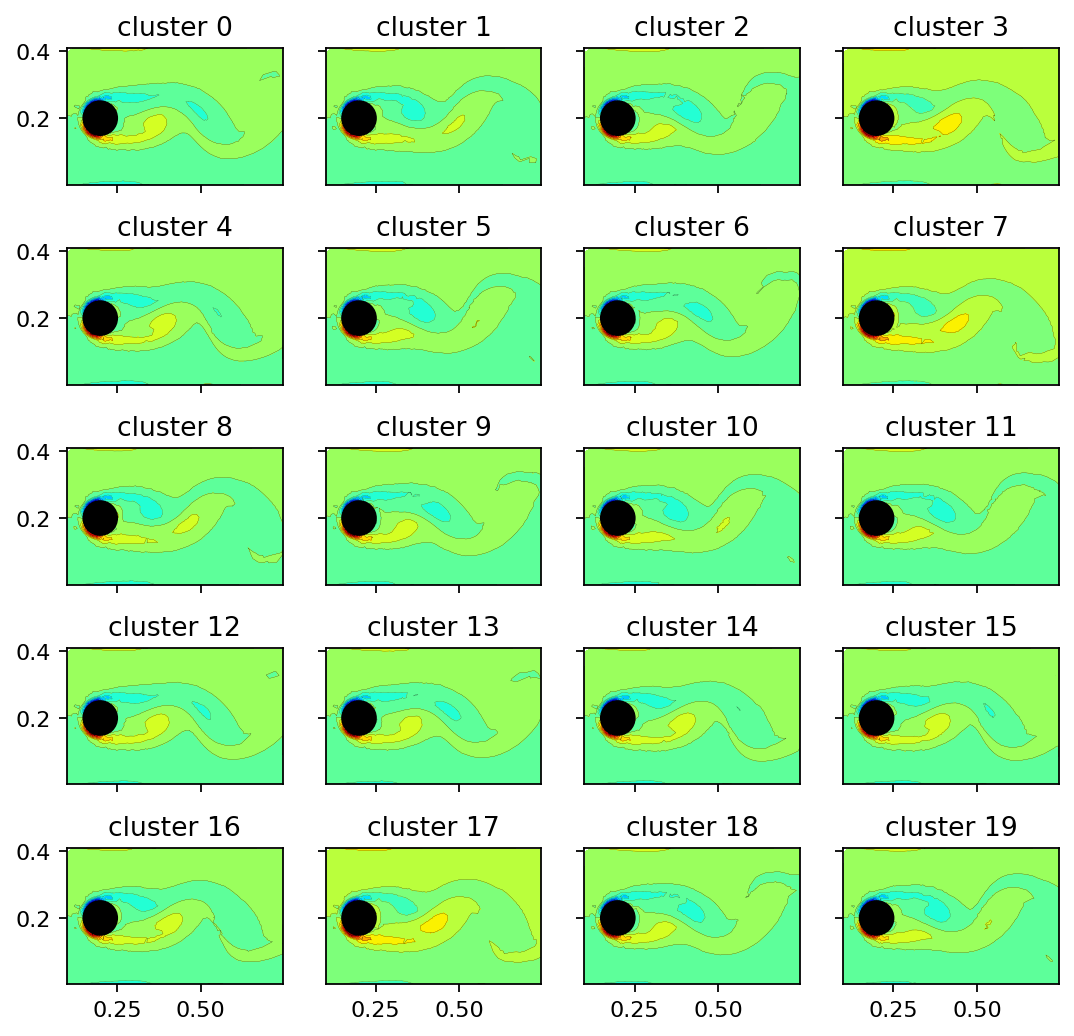

In [7]:
fig, axarr = plt.subplots(5, 4, figsize=(8, 8), sharex=True, sharey=True)
count = 0
for row in range(5):
    for col in range(4):
        add_mode(axarr[row, col], clusters_reconstructed[:, count], f"cluster {count}")
        count += 1
plt.show()

The flow dynamics are modeled and propagated in the reduced state space. The dynamics are propagated from a given initial condition using the inter-cluster transition properties over any desired time period. We visualize the main dynamics in a 2D phase space spanned by the first two cluster centroids. As the figure shows, CNM accurately captures the doinant periodic dynamics of the flow.

In [8]:
reduced_prediction = cnm.predict_reduced(reduced_state[:, :4], 1.0, dt/4)
visited_prediction = cnm._cluster.predict(reduced_prediction.T.numpy())
org_cluster_sequence = cnm.cluster_centers[cnm.visited_clusters]

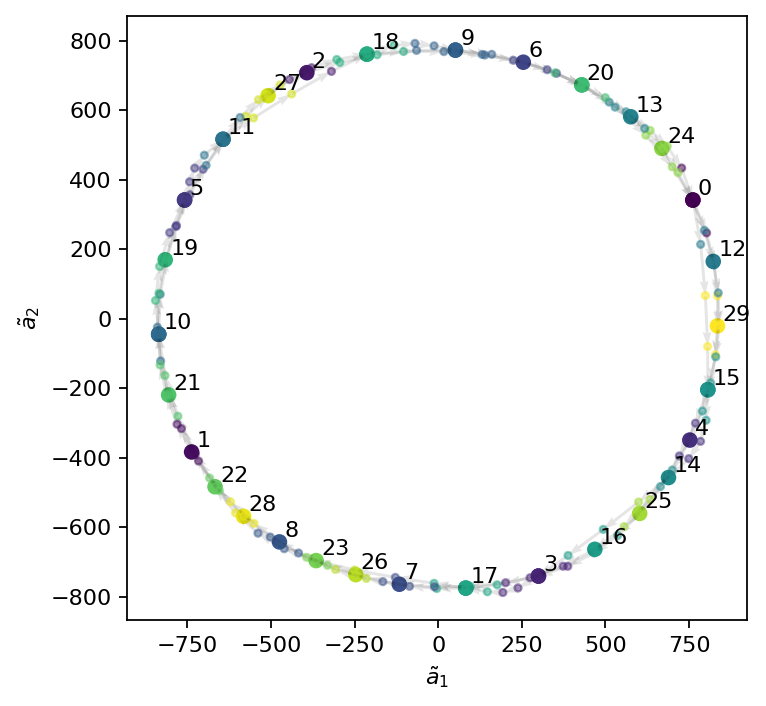

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

# plot the visited centers and color them by their label
xc = org_cluster_sequence[:, 1]
yc = org_cluster_sequence[:, 2]
ax.scatter(xc, yc, c=cnm.visited_clusters)

# plot the interpolated centers and color them by their label
xp = reduced_prediction[1, :]
yp = reduced_prediction[2, :]
ax.quiver(xp[:-1], yp[:-1], xp[1:]-xp[:-1], yp[1:]-yp[:-1], scale_units='xy', angles='xy', scale=1, color="k", alpha=0.1)
ax.scatter(xp, yp, c=visited_prediction, s=10, alpha=0.5)

# add the cluster label to each center
for i, label in enumerate(np.unique(cnm.visited_clusters)):
    cluster = cnm.cluster_centers[label, :]
    ax.text(cluster[1]+15, cluster[2]+15, f"{label}")
    
ax.set_xlabel(r"$\tilde{a}_1$")
ax.set_ylabel(r"$\tilde{a}_2$")
plt.show()

Finally. in the image sequence below, we compare the original snapshots with the CNM (full state) prediction at an interval of $0.25s$. Note that the extremely good agreement in this example results from the simple periodic dynamics. In general, CNM is desinged to predict the correct statistical behavior rather than exact agreement with the training data.

In [10]:
prediction = cnm.predict(data_matrix[:, :5], 1.0, dt)

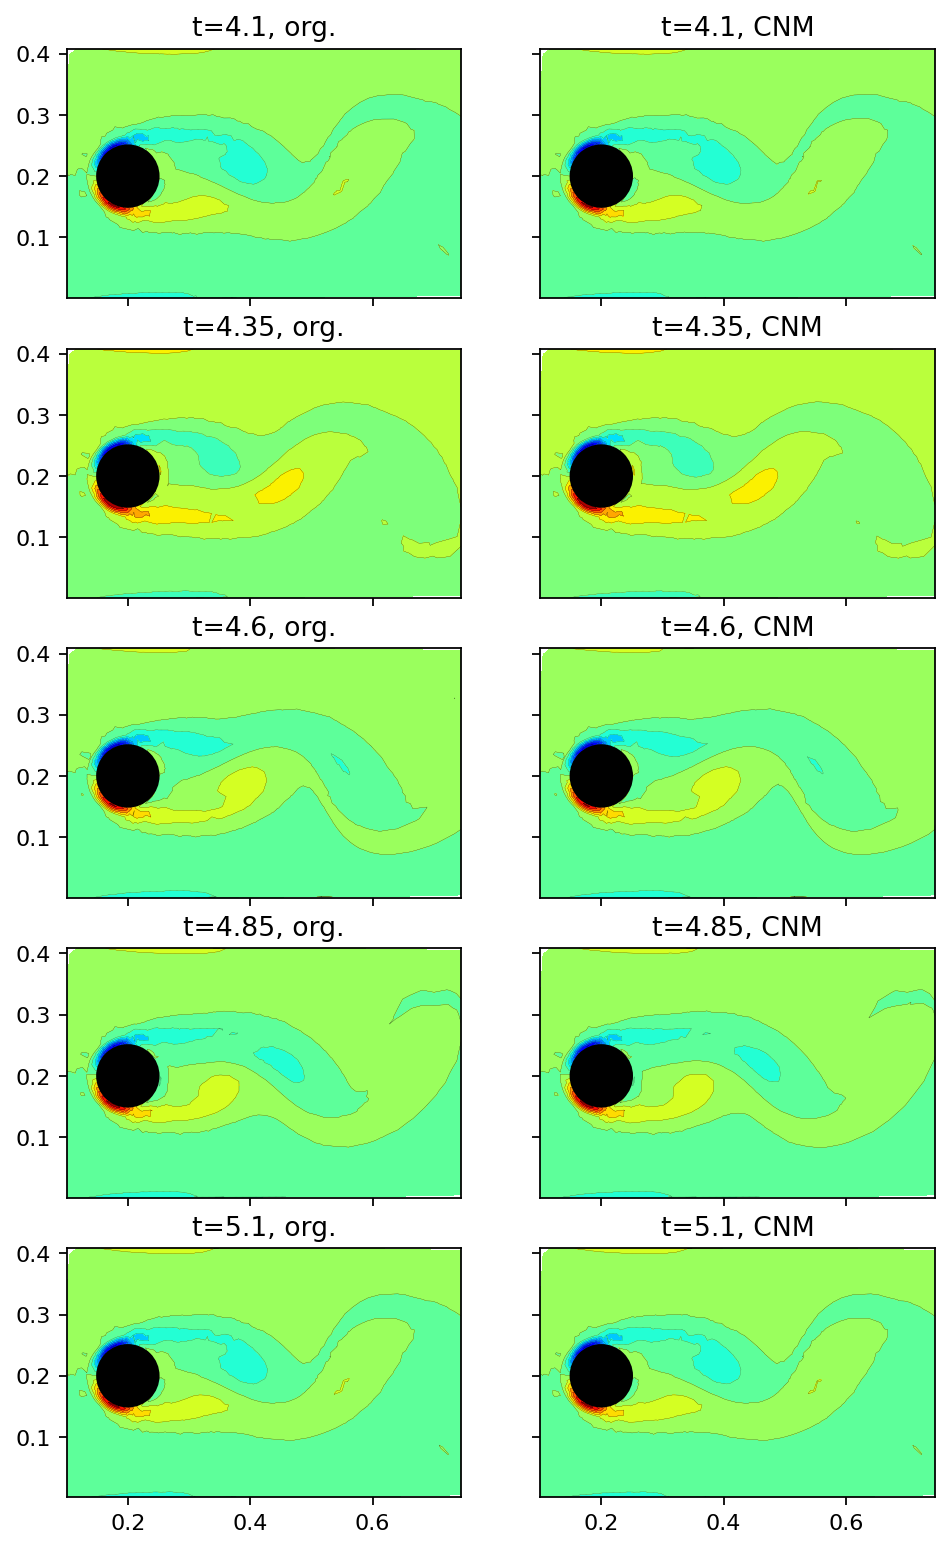

In [11]:
fig, axarr = plt.subplots(5, 2, figsize=(7, 12), sharex=True, sharey=True)
count = 0
for row in range(5):
    add_mode(axarr[row, 0], data_matrix[:, 4+count], f"t={window_times[4+count]}, org.")
    add_mode(axarr[row, 1], prediction[:, count], f"t={window_times[4+count]}, CNM")
    count += 10
plt.show()